<a href="https://colab.research.google.com/github/TristanConant/sales-predictions/blob/main/food_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [262]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
filename = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQcO5VAKyttMX8k6NqLE5Q5wHBt1ZVvuQ-Emy8aAvUOlbLrt_dcvqbBnGLtI3fDP_gAgdlmlfed1c3i/pub?gid=883441261&single=true&output=csv'
df = pd.read_csv(filename)
df.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Cleaning and exploring data

In [263]:
# How many rows and columns?
df.shape

(8523, 12)

In [264]:
# What are the datatypes of each variable?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [265]:
# Are there duplicates?
# These two columns appear to be the two identifiers that should not repeat 
df[df.duplicated(['Item_Identifier', 'Outlet_Identifier'], keep=False)]
# Double checking that the work above was done correctly
duplicate_test = df.filter(['Item_Identifier', 'Outlet_Identifier'])
duplicate_test.duplicated().sum()

0

In [266]:
# Identify missing values
# We can see that the rows with missing values exceed our 5% threshold so we will need to fill in this data
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [267]:
# Above we can see that Outlet_Size is missing from 2,410 rows. I believe we can fill in that missing data by finding the average Outlet_Size of other rows with the same Outlet_Location_Type and Outlet_Type
# E.G. All rows with a Outlet_Location_Type of 'Teir 1' and  an Outlet_Type of 'Grocery Store' have an Outlet_Size of small. So we could pretty safely assume any other rows with matching Outlet_Location_Type and Outlet_Type will also have an Outlet_Size of 'Small'
df.groupby(['Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size']).count()

Item_Identifier  \
Outlet_Location_Type Outlet_Type       Outlet_Size                    
Tier 1               Grocery Store     Small                    528   
                     Supermarket Type1 Medium                   930   
                                       Small                    930   
Tier 2               Supermarket Type1 Small                    930   
Tier 3               Supermarket Type1 High                     932   
                     Supermarket Type2 Medium                   928   
                     Supermarket Type3 Medium                   935   

                                                    Item_Weight  \
Outlet_Location_Type Outlet_Type       Outlet_Size                
Tier 1               Grocery Store     Small                  0   
                     Supermarket Type1 Medium               930   
                                       Small                930   
Tier 2               Supermarket Type1 Small                930   
Tier 3               Supermarket Type1 High                 932   
                     Supermarket Type2 Medium               928   
                     Supermarket Type3 Medium                 0   

                                                    Item_Fat_Content  \
Outlet_Location_Type Outlet_Type       Outlet_Size                     
Tier 1               Grocery Store     Small                     528   
                     Supermarket Type1 Medium                    930   
                                       Small                     930   
Tier 2               Supermarket Type1 Small                     930   
Tier 3               Supermarket Type1 High                      932   
                     Supermarket Type2 Medium                    928   
                     Supermarket Type3 Medium                    935   

                                                    Item_Visibility  \
Outlet_Location_Type Outlet_Type       Outlet_Size                    
Tier 1               Grocery Store     Small                    528   
                     Supermarket Type1 Medium                   930   
                                       Small                    930   
Tier 2               Supermarket Type1 Small                    930   
Tier 3               Supermarket Type1 High                     932   
                     Supermarket Type2 Medium                   928   
                     Supermarket Type3 Medium                   935   

                                                    Item_Type  Item_MRP  \
Outlet_Location_Type Outlet_Type       Outlet_Size                        
Tier 1               Grocery Store     Small              528       528   
                     Supermarket Type1 Medium             930       930   
                                       Small              930       930   
Tier 2               Supermarket Type1 Small              930       930   
Tier 3               Supermarket Type1 High               932       932   
                     Supermarket Type2 Medium             928       928   
                     Supermarket Type3 Medium             935       935   

                                                    Outlet_Identifier  \
Outlet_Location_Type Outlet_Type       Outlet_Size                      
Tier 1               Grocery Store     Small                      528   
                     Supermarket Type1 Medium                     930   
                                       Small                      930   
Tier 2               Supermarket Type1 Small                      930   
Tier 3               Supermarket Type1 High                       932   
                     Supermarket Type2 Medium                     928   
                     Supermarket Type3 Medium                     935   

                                                    Outlet_Establishment_Year  \
Outlet_Location_Type Outlet_Type       Outlet_Size                              
Tier 1               Gr

In [268]:
# Now we can group all of the rows where Outlet_Size is missing a group them by the Outlet_Location_Type and Outlet_Type compare the info above.
na_df = df[df['Outlet_Size'].isna()]
na_df.groupby(['Outlet_Location_Type', 'Outlet_Type']).count()

,,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales
Outlet_Location_Type,Outlet_Type,,,,,,,,,,
Tier 2,Supermarket Type1,1855,1855,1855,1855,1855,1855,1855,1855,0,1855
Tier 3,Grocery Store,555,555,555,555,555,555,555,555,0,555


In [269]:
# Rows are where Outlet_Location_Type is Tier 2 is easy to fix since every other Tier 2 has an Outlet_Size of Small
df.loc[(df['Outlet_Location_Type'] == 'Tier 2') & df['Outlet_Size'].isna(), 'Outlet_Size'] = 'Small'

In [270]:
# Rows are where Outlet_Location_Type is Tier 3 and the Outlet_Type is Grocery Store is not as straight forward. By looking at our data we see all other Grocery Store's have an Outlet_Size of Small. However Tier 3 only has Medium and High Oulet_Sizes
# I believe we can meet in the middle and make a somewhat safe assumption that Tier 3 Grocery Stores could be set to Medium
df.loc[(df['Outlet_Location_Type'] == 'Tier 3') & df['Outlet_Size'].isna(), 'Outlet_Size'] = 'Medium'
df.isna().sum()


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [271]:
# Now we need to address the missing Item_Weight values. Let's start by looking at the rows that are missing Item_Weight and try to identify a pattern
wieght_na_df = df.loc[df['Item_Weight'].isna()]
wieght_na_df.groupby('Outlet_Identifier').count()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Outlet_Identifier,,,,,,,,,,,
OUT019,528,0,528,528,528,528,528,528,528,528,528
OUT027,935,0,935,935,935,935,935,935,935,935,935


In [272]:
# My first thought was to see if any specific outlet(s) was the source of missing data. Miraculously there was a pattern there.
# Ultimately though, this was not that helpful.
df.groupby('Outlet_Identifier').count()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Outlet_Identifier,,,,,,,,,,,
OUT010,555,555,555,555,555,555,555,555,555,555,555
OUT013,932,932,932,932,932,932,932,932,932,932,932
OUT017,926,926,926,926,926,926,926,926,926,926,926
OUT018,928,928,928,928,928,928,928,928,928,928,928
OUT019,528,0,528,528,528,528,528,528,528,528,528
OUT027,935,0,935,935,935,935,935,935,935,935,935
OUT035,930,930,930,930,930,930,930,930,930,930,930
OUT045,929,929,929,929,929,929,929,929,929,929,929
OUT046,930,930,930,930,930,930,930,930,930,930,930


In [273]:
# I don't have a specific resource for the following code. I just used trial and error until I was able to get the cell to do what I wanted it to do.
# Get all item ids where the weight is missing. Transform it into a set to reduce all duplicates.
weight_na = set(df[df['Item_Weight'].isna()]['Item_Identifier'])
# Loop over the item ids
for item_id in weight_na:
  # Get the series of values where the item_id matches and the weight is not na.
  item_weight = df.loc[(df['Item_Identifier'] == item_id) & df['Item_Weight'].notna(), 'Item_Weight']
  # Make sure that a valid item was found
  if not item_weight.empty:
    # Set the missing weight values to the first item found in the series
    df.loc[(df['Item_Identifier'] == item_id) & df['Item_Weight'].isna(), 'Item_Weight'] = item_weight.iloc[0]
# Check the work
df.isna().sum()


Item_Identifier              0
Item_Weight                  4
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [274]:
# 4 items are still missing a weight value. This is well below the 5% threshold so we can safely drop those rows.
df.dropna(inplace=True)
# Check the work
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [275]:
# Look at the overview of datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                8519 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


In [276]:
# Loop over object types and return a count of each unique value to look for inconsistencies
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index

for col in str_cols:
  print(f'Column: {col}')
  print(df[col].value_counts())
  print('\n\n')

Column: Item_Identifier
FDG33    10
FDW13    10
FDV60     9
FDU12     9
FDX20     9
         ..
DRF48     1
FDY43     1
FDC23     1
FDO33     1
FDT35     1
Name: Item_Identifier, Length: 1555, dtype: int64



Column: Item_Fat_Content
Low Fat    5088
Regular    2886
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



Column: Item_Type
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



Column: Outlet_Identifier
OUT013    932
OUT027    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT01

In [277]:
# Fixing the inconsistencies in fat content
df['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace=True)
df['Item_Fat_Content'].replace('LF', 'Low Fat', inplace=True)
df['Item_Fat_Content'].replace('reg', 'Regular', inplace=True)

for col in str_cols:
  print(f'Column: {col}')
  print(df[col].value_counts())
  print('\n\n')

Column: Item_Identifier
FDG33    10
FDW13    10
FDV60     9
FDU12     9
FDX20     9
         ..
DRF48     1
FDY43     1
FDC23     1
FDO33     1
FDT35     1
Name: Item_Identifier, Length: 1555, dtype: int64



Column: Item_Fat_Content
Low Fat    5516
Regular    3003
Name: Item_Fat_Content, dtype: int64



Column: Item_Type
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



Column: Outlet_Identifier
OUT013    932
OUT027    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    5

In [278]:
# Look for any oddities in the other columns
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779
std,4.646098,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


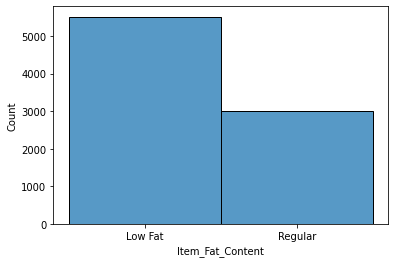

In [279]:
sns.histplot(data=df, x='Item_Fat_Content');

The histogram above shows that there are nearly double the amount of low fat food items than regular.

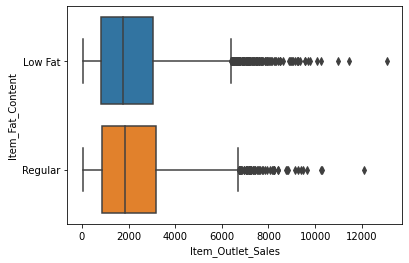

In [280]:
sns.boxplot(data=df, x='Item_Outlet_Sales', y='Item_Fat_Content');

The boxplot shows that on average regular items sold just slightly more than low fat.

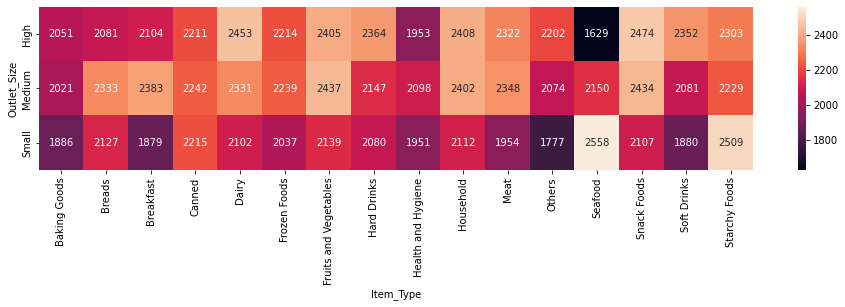

In [281]:
by_type = df.groupby(['Item_Type', 'Outlet_Size',]).agg('mean').unstack('Item_Type')
# print(by_type['Item_Outlet_Sales'].apply(np.ceil))
plt.figure(figsize=(16, 3))
sns.heatmap(by_type['Item_Outlet_Sales'].round(), annot=True, fmt='g');

The heatmap shows the sales of each outlet size broken down by item type.